# Analyse de la maintenance prédictive

**Méthodologie:**

- Construire des features par cycle

- Comparer plusieurs modèles sur les 2000 premiers cycles

- Utiliser une validation croisée

- Sélectionner le meilleur modèle

- Évaluer sa performance finale sur les 205 cycles restants (jeu de test final, jamais vu)

👉 un train / validation / test propre

# Préparation des données

Charger les données

In [2]:
import os
import pandas as pd

# Chemins des fichiers
ps2_path = "../data/PS2.txt"
fs1_path = "../data/FS1.txt"
profile_path = "../data/profile.txt"

# Vérifier existence
for path in [ps2_path, fs1_path, profile_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable : {path}")

# Charger les fichiers capteurs
ps2 = pd.read_csv(ps2_path, sep="\t", header=None)
fs1 = pd.read_csv(fs1_path, sep="\t", header=None)

# Charger le fichier profile
profile = pd.read_csv(profile_path, sep="\t", header=None)
profile.columns = ["cooler_condition", "valve_condition", "pump_leakage", "accumulator_pressure", "stable_flag"]


Création de la variable cible (binaire)

In [3]:
# 1100% = optimal (0) vs Non optimal (1)
y = (profile["valve_condition"] != 100).astype(int)

In [4]:
y.value_counts()

valve_condition
0    1125
1    1080
Name: count, dtype: int64

Feature engineering

In [5]:
import numpy as np

def extract_features(df, df_name):
    return pd.DataFrame({
        f"{df_name}_mean": df.mean(axis=1),
        f"{df_name}_std": df.std(axis=1),
        f"{df_name}_min": df.min(axis=1),
        f"{df_name}_max": df.max(axis=1)
    })

X_ps2 = extract_features(ps2, "ps2")
X_fs1 = extract_features(fs1, "fs1")

XX = pd.concat([X_ps2, X_fs1], axis=1)


In [6]:
XX.describe()

,ps2_mean,ps2_std,ps2_min,ps2_max,fs1_mean,fs1_std,fs1_min,fs1_max
count,2205.000000,2205.000000,2205.0,2205.000000,2205.000000,2205.000000,2.205000e+03,2205.000000
mean,109.379906,47.736162,0.0,166.520517,6.198549,3.040077,4.535147e-07,20.130214
std,4.986585,3.271949,0.0,0.977997,1.032883,0.189007,2.129589e-05,0.451934
min,104.406307,45.206954,0.0,155.040000,2.018572,2.665898,0.000000e+00,18.698000
25%,106.962382,46.209665,0.0,166.180000,6.391670,2.956965,0.000000e+00,19.881000
50%,107.730169,46.805986,0.0,166.650000,6.576673,2.984821,0.000000e+00,20.363000
75%,109.421612,47.207567,0.0,167.100000,6.657508,3.020458,0.000000e+00,20.479000
max,131.589089,59.553248,0.0,167.770000,6.722707,3.742224,1.000000e-03,20.479000


Suppression des minimaux (trop proche de zéo)

In [7]:
X = XX.drop(columns=[ "ps2_min","fs1_min"])

# Diviser le jeu de données en train / test final

In [8]:
# les 2000 premiers cycles
X_train = X.iloc[:2000] 
y_train = y.iloc[:2000]

# les 205 derniers cycles
X_test = X.iloc[2000:] 
y_test = y.iloc[2000:]

In [9]:
# Verification des dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 6), (2000,), (205, 6), (205,))

# Pipelines + modèles

Load packages

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Modèles comparés

In [11]:
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

XGBoost

In [12]:
from xgboost import XGBClassifier

models["XGBoost"] = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


# Validation croisée sur les 2000 cycles

In [13]:
from sklearn.model_selection import cross_validate

results = {}

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=["accuracy", "f1", "recall", "precision"]
    )
    results[name] = {
        "accuracy": scores["test_accuracy"].mean(),
        "f1-score": scores["test_f1"].mean(),
        "recall": scores["test_recall"].mean(),
        "precision": scores["test_precision"].mean()
    }

pd.DataFrame(results).T


,accuracy,f1-score,recall,precision
LogisticRegression,0.8260,0.784559,0.707018,0.944937
DecisionTree,0.7925,0.790623,0.807034,0.818637
RandomForest,0.8185,0.828417,0.882762,0.821531
XGBoost,0.8285,0.836183,0.860757,0.845224


# Sélection du meilleur modèle

**XGBoost est le meilleur modèle globalement**

Détecter les cycles NON optimaux (classe 1):

- minimiser les défauts non détectés (FN)

- maximiser le recall, tout en gardant un bon équilibre global.

- Le F1-score est la métrique de choix

In [14]:
best_model_name = "XGBoost"
best_model = models[best_model_name]


# Entraînement final sur les 2000 cycles

In [15]:
best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

# Évaluation finale sur les 205 cycles

In [24]:
X_test.tail()

,ps2_mean,ps2_std,ps2_max,fs1_mean,fs1_std,fs1_max
2200,109.779581,47.253414,167.49,6.689930,3.001512,20.228
2201,109.787481,47.247815,167.27,6.692182,3.005831,20.308
2202,109.756174,47.244805,167.34,6.693277,2.991333,20.071
2203,109.793884,47.240806,167.52,6.684128,3.003983,20.280
2204,109.792177,47.238665,167.34,6.692302,3.007413,20.395


In [21]:
y_test.tail()

2200    0
2201    0
2202    0
2203    0
2204    0
Name: valve_condition, dtype: int64

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 73   0]
 [ 27 105]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        73
           1       1.00      0.80      0.89       132

    accuracy                           0.87       205
   macro avg       0.86      0.90      0.87       205
weighted avg       0.90      0.87      0.87       205



| Réel \ Prédit       | Optimal (0) | Non optimal (1) |
| ------------------- | ----------- | --------------- |
| **Optimal (0)**     | 73 ✅       | 0 ❌           |
| **Non optimal (1)** | 27 ⚠️       | 105 ✅         |


**Interprétation**

**⚠️ Cycles non optimaux (classe 1)**

- 105 défauts correctement détectés

- 27 défauts ratés (FN)

👉 Environ 20 % des défauts ne sont pas détectés

**Classe 1 = NON optimal (prioritaire)**

- Recall = 0.80

👉 Le modèle détecte 80 % des cycles non optimaux

👉 20 % échappent à la détection (risque métier)

- Precision = 1.00

👉 Chaque alerte correspond à un vrai problème

👉 Aucune fausse alerte

- F1-score = 0.89

👉 Très bon compromis détection / fiabilité

🔹 Accuracy globale = 0.87

- 87 % des cycles correctement classés

# Importance des variables

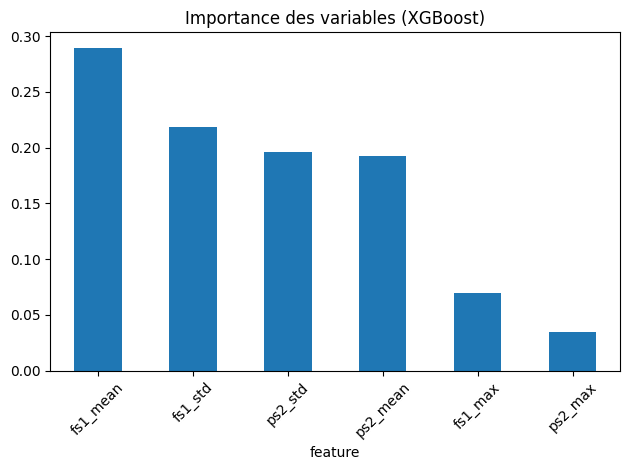

In [17]:

import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.feature_importances_

features = X_train.columns

df_imp = (
    pd.DataFrame({
        "feature": features,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

df_imp.plot(
    x="feature",
    y="importance",
    kind="bar",
    legend=False
)


# Incliner les labels de l'axe X à 45°
plt.xticks(rotation=45)

plt.title("Importance des variables (XGBoost)")
plt.tight_layout()  # Pour éviter que les labels se chevauchent
plt.show()



**Interprétation du résultat**

👉 fs1_mean et fs1_std sont les variables les plus importantes signifie que :

- Le débit volumique (FS1) est le signal le plus discriminant pour prédire l’état de la valve

- Les variations de débit (instabilité, dispersion) sont fortement corrélées à une dégradation de la valve

- Une valve défectueuse impacte directement :

   - le niveau moyen de débit

   - la variabilité du débit pendant le cycle

➡️ Cohérence des résultats

Une dégradation de la valve entraîne une perte de contrôle du débit hydraulique, se traduisant par des variations accrues et une diminution du débit moyen. Ces phénomènes sont capturés par les statistiques fs1_mean et fs1_std, qui apparaissent comme les variables les plus contributives dans le modèle.

Les modèles ont été comparés à l’aide d’une validation croisée à 5 plis sur les 2000 premiers cycles.
Le modèle présentant les meilleures performances moyennes (F1-score) a été sélectionné.
Ce modèle a ensuite été entraîné sur l’ensemble des 2000 cycles, puis évalué sur les 205 cycles restants, constituant un jeu de test indépendant.